In [1]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from prophet import Prophet
import datetime as dt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

In [2]:
# Load data
a_path = Path("Resources/world_population_data.csv")
b_path = Path("Resources/Production_Crops_Livestock_E_All_Data.csv")
c_path = Path("Resources/API_SP.POP.TOTL_DS2_en_csv_v2_3401680.csv")
d_path = Path("Resources/Lists_test.csv")
world_population = pd.read_csv(a_path)
agri_data = pd.read_csv(b_path, encoding='ISO-8859-1', low_memory = False)
world_population_all_years = pd.read_csv(c_path)
category_ag_data = pd.read_csv(d_path)

In [3]:
# Import Widgets to have dropdown menus
import ipywidgets as widgets 
from IPython.display import display

In [4]:
# Options for dropdown menu
options = ['Asia', 'Europe', 'Africa', 'North America', 'South America',
       'Oceania']

In [5]:
# Dropdown menu
dropdown = widgets.Dropdown(options=options, value=options[0], description='Select')

In [6]:
# Display dropdown menu
display(dropdown)

Dropdown(description='Select', options=('Asia', 'Europe', 'Africa', 'North America', 'South America', 'Oceania…

In [7]:
# View Agricultural data
agri_data.info()
agri_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79607 entries, 0 to 79606
Columns: 195 entries, Area Code to Y2022N
dtypes: float64(62), int64(3), object(130)
memory usage: 118.4+ MB


,Area Code,Area Code (M49),Area,Item Code,Item Code (CPC),Item,Element Code,Element,Unit,Y1961,...,Y2019N,Y2020,Y2020F,Y2020N,Y2021,Y2021F,Y2021N,Y2022,Y2022F,Y2022N
0,2,'004,Afghanistan,221,'01371,"Almonds, in shell",5312,Area harvested,ha,0.0,...,NaN,22134.0,A,NaN,36862.0,A,NaN,37000.0,A,NaN
1,2,'004,Afghanistan,221,'01371,"Almonds, in shell",5419,Yield,100 g/ha,NaN,...,NaN,17759.0,A,NaN,17432.0,A,NaN,17297.0,A,NaN
2,2,'004,Afghanistan,221,'01371,"Almonds, in shell",5510,Production,t,0.0,...,NaN,39307.0,A,NaN,64256.0,A,NaN,64000.0,A,NaN
3,2,'004,Afghanistan,711,'01654,"Anise, badian, coriander, cumin, caraway, fenn...",5312,Area harvested,ha,0.0,...,NaN,25558.0,E,NaN,25357.0,E,NaN,25403.0,E,NaN
4,2,'004,Afghanistan,711,'01654,"Anise, badian, coriander, cumin, caraway, fenn...",5419,Yield,100 g/ha,NaN,...,NaN,7030.0,E,NaN,7050.0,E,NaN,7040.0,E,NaN


In [8]:
# View uniqe values in items, use this data to create csv with categories for group mapping
agri_data["Item"].unique()

array(['Almonds, in shell',
       'Anise, badian, coriander, cumin, caraway, fennel and juniper berries, raw',
       'Apples', 'Apricots', 'Asses', 'Barley',
       'Butter and ghee of sheep milk', 'Butter of cow milk',
       'Buttermilk, dry', 'Camels', 'Cantaloupes and other melons',
       'Cattle', 'Cattle fat, unrendered',
       'Cheese from milk of goats, fresh or processed',
       'Cheese from milk of sheep, fresh or processed', 'Chickens',
       'Cotton lint, ginned', 'Cotton seed', 'Cottonseed oil',
       'Edible offal of cattle, fresh, chilled or frozen',
       'Edible offal of goat, fresh, chilled or frozen',
       'Edible offal of sheep, fresh, chilled or frozen',
       'Edible offals of camels and other camelids, fresh, chilled or frozen',
       'Fat of camels', 'Figs', 'Game meat, fresh, chilled or frozen',
       'Goat fat, unrendered', 'Goats', 'Grapes',
       'Hen eggs in shell, fresh', 'Horses', 'Linseed', 'Maize (corn)',
       'Meat of camels, fresh or c

In [9]:
# View Columns to determine which columns to keep or drop
print(agri_data.columns)

Index(['Area Code', 'Area Code (M49)', 'Area', 'Item Code', 'Item Code (CPC)',
       'Item', 'Element Code', 'Element', 'Unit', 'Y1961',
       ...
       'Y2019N', 'Y2020', 'Y2020F', 'Y2020N', 'Y2021', 'Y2021F', 'Y2021N',
       'Y2022', 'Y2022F', 'Y2022N'],
      dtype='object', length=195)


In [10]:
#Drop columns that are not needed
columns_to_drop =["Area Code", "Area Code (M49)", "Item Code", "Item Code (CPC)", "Element Code", "Element"]
agri_data.drop(columns=columns_to_drop, inplace=True)

# Rename Area to Country
agri_data = agri_data.rename(columns={"Area": "Country"})

#Remove Y from year
agri_data.columns = agri_data.columns.str.replace("Y", "")

# Display df
agri_data.head()

,Country,Item,Unit,1961,1961F,1961N,1962,1962F,1962N,1963,...,2019N,2020,2020F,2020N,2021,2021F,2021N,2022,2022F,2022N
0,Afghanistan,"Almonds, in shell",ha,0.0,A,NaN,0.0,A,NaN,0.0,...,NaN,22134.0,A,NaN,36862.0,A,NaN,37000.0,A,NaN
1,Afghanistan,"Almonds, in shell",100 g/ha,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,17759.0,A,NaN,17432.0,A,NaN,17297.0,A,NaN
2,Afghanistan,"Almonds, in shell",t,0.0,A,NaN,0.0,A,NaN,0.0,...,NaN,39307.0,A,NaN,64256.0,A,NaN,64000.0,A,NaN
3,Afghanistan,"Anise, badian, coriander, cumin, caraway, fenn...",ha,0.0,M,NaN,0.0,M,NaN,0.0,...,NaN,25558.0,E,NaN,25357.0,E,NaN,25403.0,E,NaN
4,Afghanistan,"Anise, badian, coriander, cumin, caraway, fenn...",100 g/ha,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,7030.0,E,NaN,7050.0,E,NaN,7040.0,E,NaN


In [11]:
# remove columns that do not hold numerical example 1962F and 1962N 
columns_to_drop2 = [col for col in agri_data.columns if col.endswith('F') or col.endswith('N')]
df_cleaned = agri_data.drop(columns=columns_to_drop2)
df_cleaned.head()

,Country,Item,Unit,1961,1962,1963,1964,1965,1966,1967,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Afghanistan,"Almonds, in shell",ha,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14114.0,13703.0,14676.0,19481.0,19793.0,20053.0,29203.0,22134.0,36862.0,37000.0
1,Afghanistan,"Almonds, in shell",100 g/ha,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,29910.0,19996.0,16521.0,16859.0,13788.0,17161.0,13083.0,17759.0,17432.0,17297.0
2,Afghanistan,"Almonds, in shell",t,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,42215.0,27400.0,24246.0,32843.0,27291.0,34413.0,38205.0,39307.0,64256.0,64000.0
3,Afghanistan,"Anise, badian, coriander, cumin, caraway, fenn...",ha,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,18500.0,30000.0,25000.0,24500.0,26160.0,25220.0,25293.0,25558.0,25357.0,25403.0
4,Afghanistan,"Anise, badian, coriander, cumin, caraway, fenn...",100 g/ha,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6757.0,7167.0,7200.0,7075.0,6970.0,7080.0,7041.0,7030.0,7050.0,7040.0


In [12]:
#Display category data for Ag dataset
category_ag_data.info()
category_ag_data.head()
category_ag_data['Category'].unique()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Item      156 non-null    object
 1   Category  156 non-null    object
dtypes: object(2)
memory usage: 2.6+ KB


array(['Dairy', 'Eggs', 'Fruit', 'Grain', 'Honey', 'Meat', 'Nut', 'Sugar',
       'Vegetable'], dtype=object)

In [13]:
# Make category_ag_data.set a dictionary and set index
group_mapping = category_ag_data.set_index('Item')['Category'].to_dict()

In [14]:
# Create a new column named 'Category' in df based on 'Item' defined in group_mapping
df_cleaned['Category'] = df_cleaned['Item'].replace(group_mapping)
df_cleaned.head()

,Country,Item,Unit,1961,1962,1963,1964,1965,1966,1967,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,Category
0,Afghanistan,"Almonds, in shell",ha,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13703.0,14676.0,19481.0,19793.0,20053.0,29203.0,22134.0,36862.0,37000.0,Nut
1,Afghanistan,"Almonds, in shell",100 g/ha,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19996.0,16521.0,16859.0,13788.0,17161.0,13083.0,17759.0,17432.0,17297.0,Nut
2,Afghanistan,"Almonds, in shell",t,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,27400.0,24246.0,32843.0,27291.0,34413.0,38205.0,39307.0,64256.0,64000.0,Nut
3,Afghanistan,"Anise, badian, coriander, cumin, caraway, fenn...",ha,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,30000.0,25000.0,24500.0,26160.0,25220.0,25293.0,25558.0,25357.0,25403.0,"Anise, badian, coriander, cumin, caraway, fenn..."
4,Afghanistan,"Anise, badian, coriander, cumin, caraway, fenn...",100 g/ha,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7167.0,7200.0,7075.0,6970.0,7080.0,7041.0,7030.0,7050.0,7040.0,"Anise, badian, coriander, cumin, caraway, fenn..."


In [15]:
# Filter Units column for Tonnes, Animals or 1000 Animals
filtered_df = df_cleaned[df_cleaned['Unit'].isin(['t', 'An', '1000 An'])]

# Filter out items that do have assigned categories
categories_to_keep = ['Dairy', 'Eggs', 'Fruit', 'Grain', 'Honey', 'Meat', 'Nut', 'Sugar', 'Vegetable']
filtered_df = filtered_df[filtered_df['Category'].isin(categories_to_keep)]

#Re-order Dataframe
columns = filtered_df.columns.tolist()
category_index = columns.index('Category')
columns.insert(2, columns.pop(category_index))
ag_df = filtered_df[columns]
ag_df.head()

#Display DF
ag_df.head()

,Country,Item,Category,Unit,1961,1962,1963,1964,1965,1966,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
2,Afghanistan,"Almonds, in shell",Nut,t,0.0,0.0,0.0,0.0,0.0,0.0,...,42215.0,27400.0,24246.0,32843.0,27291.0,34413.0,38205.0,39307.0,64256.0,64000.00
8,Afghanistan,Apples,Fruit,t,15100.0,15100.0,15100.0,18400.0,20400.0,22800.0,...,78597.0,89403.0,89733.0,140903.0,170443.0,217192.0,250324.0,270857.0,321672.0,318000.00
11,Afghanistan,Apricots,Fruit,t,32000.0,32000.0,32000.0,39200.0,43400.0,48400.0,...,90000.0,90000.0,87686.0,17894.0,131816.0,109086.0,129363.0,131788.0,207490.0,170507.92
12,Afghanistan,Asses,Meat,An,1300000.0,851850.0,1001112.0,1150000.0,1300000.0,1200000.0,...,1451000.0,1441000.0,1481000.0,1472100.0,1317000.0,1329850.0,1552264.0,1534307.0,1552976.0,1571646.00
15,Afghanistan,Barley,Grain,t,378000.0,378000.0,378000.0,380000.0,380000.0,375000.0,...,514000.0,521000.0,403000.0,301856.0,94995.0,56781.0,123576.0,127757.0,65102.0,110000.00


In [16]:
# Convert 1000 An to An so that all animals can be combined using same values
# Identify rows with '1000 An' in the 'Unit' column
multiply_by = ag_df['Unit'] == '1000 An'

# Multiply the values by 1000 where 'Unit' is '1000 An'
ag_df.loc[multiply_by, ag_df.columns[4:]] = ag_df.loc[multiply_by, ag_df.columns[4:]].multiply(1000)

# Use .loc to replace '1000 An' with 'An' in the 'Unit' column
ag_df.loc[ag_df['Unit'] == '1000 An', 'Unit'] = 'An'

# Display DF
ag_df.head()

,Country,Item,Category,Unit,1961,1962,1963,1964,1965,1966,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
2,Afghanistan,"Almonds, in shell",Nut,t,0.0,0.0,0.0,0.0,0.0,0.0,...,42215.0,27400.0,24246.0,32843.0,27291.0,34413.0,38205.0,39307.0,64256.0,64000.00
8,Afghanistan,Apples,Fruit,t,15100.0,15100.0,15100.0,18400.0,20400.0,22800.0,...,78597.0,89403.0,89733.0,140903.0,170443.0,217192.0,250324.0,270857.0,321672.0,318000.00
11,Afghanistan,Apricots,Fruit,t,32000.0,32000.0,32000.0,39200.0,43400.0,48400.0,...,90000.0,90000.0,87686.0,17894.0,131816.0,109086.0,129363.0,131788.0,207490.0,170507.92
12,Afghanistan,Asses,Meat,An,1300000.0,851850.0,1001112.0,1150000.0,1300000.0,1200000.0,...,1451000.0,1441000.0,1481000.0,1472100.0,1317000.0,1329850.0,1552264.0,1534307.0,1552976.0,1571646.00
15,Afghanistan,Barley,Grain,t,378000.0,378000.0,378000.0,380000.0,380000.0,375000.0,...,514000.0,521000.0,403000.0,301856.0,94995.0,56781.0,123576.0,127757.0,65102.0,110000.00


In [17]:
#Display world_population dataset

display(world_population.head())

,rank,cca3,country,continent,2023 population,2022 population,2020 population,2015 population,2010 population,2000 population,1990 population,1980 population,1970 population,area (km²),density (km²),growth rate,world percentage
0,1,IND,India,Asia,1428627663,1417173173,1396387127,1322866505,1240613620,1059633675,870452165,696828385,557501301,3287590.0,481,0.81%,17.85%
1,2,CHN,China,Asia,1425671352,1425887337,1424929781,1393715448,1348191368,1264099069,1153704252,982372466,822534450,9706961.0,151,-0.02%,17.81%
2,3,USA,United States,North America,339996563,338289857,335942003,324607776,311182845,282398554,248083732,223140018,200328340,9372610.0,37,0.50%,4.25%
3,4,IDN,Indonesia,Asia,277534122,275501339,271857970,259091970,244016173,214072421,182159874,148177096,115228394,1904569.0,148,0.74%,3.47%
4,5,PAK,Pakistan,Asia,240485658,235824862,227196741,210969298,194454498,154369924,115414069,80624057,59290872,881912.0,312,1.98%,3.00%


In [18]:
#Add 'Continent' column to ag_df, by merging world_popultion dataset
columns_to_drop2 =["2023 population", "cca3", "2022 population", "2020 population", "2015 population", "2010 population", "2000 population", "1990 population", "1980 population", "1970 population"]
world_population.drop(columns=columns_to_drop2, inplace=True)
world_population.rename(columns={"country": "Country", "continent": "Continent"}, inplace=True)

# Create new df, for this merge and keep world_population for later use below
wp_for_merge = world_population.copy()
columns_to_drop3 =["rank", "area (km²)", "density (km²)", "growth rate", "world percentage"]
wp_for_merge.drop(columns=columns_to_drop3, inplace=True)

# Merge Dataset using inner 
ag_df_fnl = pd.merge(ag_df, wp_for_merge, on= "Country", how="inner")

#Re-order Dataframe
columns = ag_df_fnl.columns.tolist()
category_index = columns.index('Continent')
columns.insert(1, columns.pop(category_index))
ag_df_fnl = ag_df_fnl[columns]

# Filter out rows where 'Unit' is 'An' and 'Category' is not 'Meat'
ag_df_fnl = ag_df_fnl.drop(ag_df_fnl[(ag_df_fnl['Unit'] == 'An') & (ag_df_fnl['Category'] != 'Meat')].index)

# Display DF
ag_df_fnl.head()

,Country,Continent,Item,Category,Unit,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Afghanistan,Asia,"Almonds, in shell",Nut,t,0.0,0.0,0.0,0.0,0.0,...,42215.0,27400.0,24246.0,32843.0,27291.0,34413.0,38205.0,39307.0,64256.0,64000.00
1,Afghanistan,Asia,Apples,Fruit,t,15100.0,15100.0,15100.0,18400.0,20400.0,...,78597.0,89403.0,89733.0,140903.0,170443.0,217192.0,250324.0,270857.0,321672.0,318000.00
2,Afghanistan,Asia,Apricots,Fruit,t,32000.0,32000.0,32000.0,39200.0,43400.0,...,90000.0,90000.0,87686.0,17894.0,131816.0,109086.0,129363.0,131788.0,207490.0,170507.92
3,Afghanistan,Asia,Asses,Meat,An,1300000.0,851850.0,1001112.0,1150000.0,1300000.0,...,1451000.0,1441000.0,1481000.0,1472100.0,1317000.0,1329850.0,1552264.0,1534307.0,1552976.0,1571646.00
4,Afghanistan,Asia,Barley,Grain,t,378000.0,378000.0,378000.0,380000.0,380000.0,...,514000.0,521000.0,403000.0,301856.0,94995.0,56781.0,123576.0,127757.0,65102.0,110000.00


In [19]:
ag_df_fnl.to_csv("ag_df_fnl.csv", index=False)

In [20]:
# Do statistical analysis on Ag Dataset
# Melt the DataFrame: Convert year columns into a single 'Year' and 'Production' column
melted_ag_df = ag_df_fnl.melt(
    id_vars=['Continent', 'Category'],  # Keep these columns intact
    var_name='Year',                    # New column name for years
    value_name='Production'             # New column name for production values
)

# Convert 'Production' to numeric, coercing errors to NaN
melted_ag_df['Production'] = pd.to_numeric(melted_ag_df['Production'], errors='coerce')

# Drop rows with missing production values
melted_ag_df = melted_ag_df.dropna(subset=['Production'])

# Convert Year to date time
melted_ag_df['Year'] = pd.to_datetime(melted_ag_df['Year'], format='%Y')

# Display the first few rows of the melted DataFrame to verify structure
print(melted_ag_df.head())

# Group by Continent and Category and calculate summary statistics
summary_stats = melted_ag_df.groupby(['Continent', 'Category'])['Production'].agg(['sum', 'mean', 'min', 'max', 'std']).reset_index()

# Display the aggregated statistics
print("\nSummary Statistics by Category and Continent:")
print(summary_stats)

      Continent Category       Year  Production
36618      Asia      Nut 1961-01-01         0.0
36619      Asia    Fruit 1961-01-01     15100.0
36620      Asia    Fruit 1961-01-01     32000.0
36621      Asia     Meat 1961-01-01   1300000.0
36622      Asia    Grain 1961-01-01    378000.0

Summary Statistics by Category and Continent:
        Continent   Category           sum          mean   min           max  \
0          Africa      Dairy  3.054853e+09  1.736107e+05   0.0  6.230815e+06   
1          Africa       Eggs  1.977942e+08  3.361561e+04   0.0  7.108267e+05   
2          Africa      Fruit  3.558218e+09  1.257632e+05   0.0  1.175644e+07   
3          Africa      Grain  6.021356e+09  4.330353e+05   0.0  1.755100e+07   
4          Africa      Honey  5.835011e+06  4.097620e+03   0.0  6.622100e+04   
5          Africa       Meat  1.269658e+11  3.973021e+06   0.0  3.000000e+08   
6          Africa        Nut  5.467729e+08  6.736145e+04   0.0  4.600000e+06   
7          Africa      Su

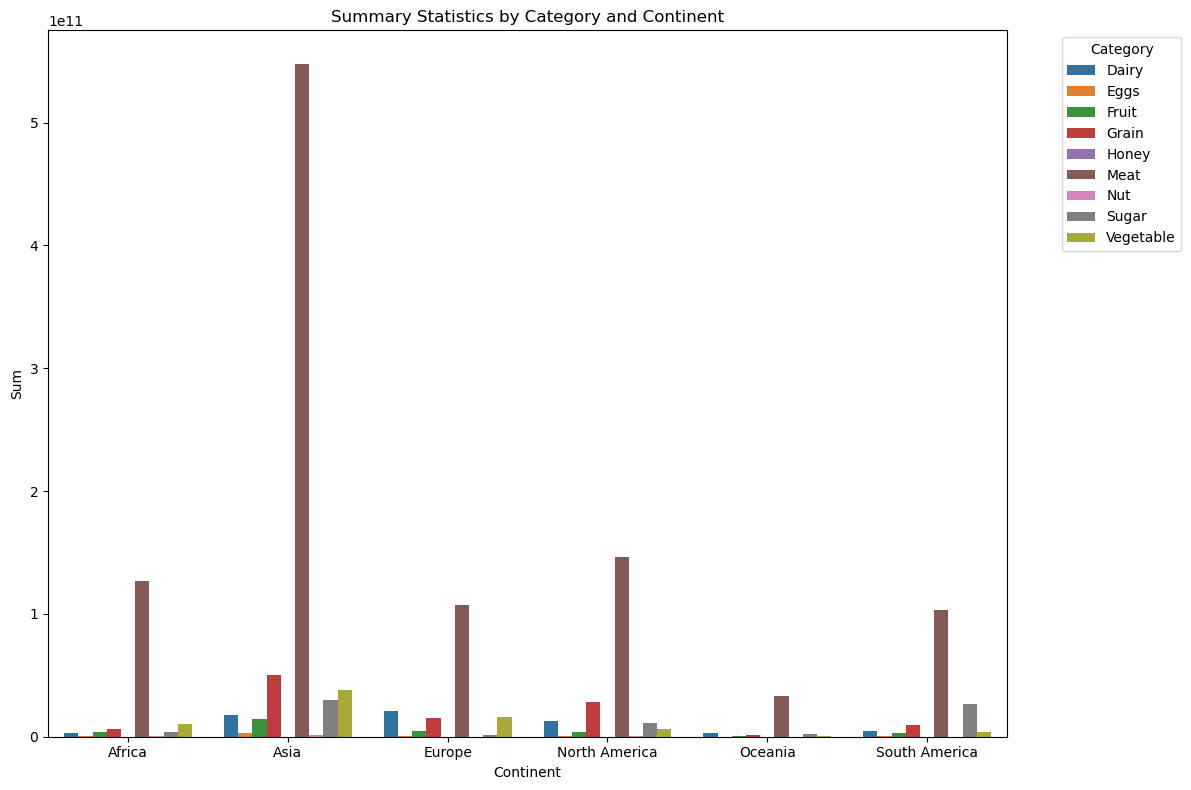

In [21]:
plt.figure(figsize=(12, 8)) 
sns.barplot(x='Continent', y='sum', hue='Category', data=summary_stats, errorbar=None) 
plt.title('Summary Statistics by Category and Continent') 
plt.xlabel('Continent') 
plt.ylabel('Sum') 
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.tight_layout() 
plt.show()

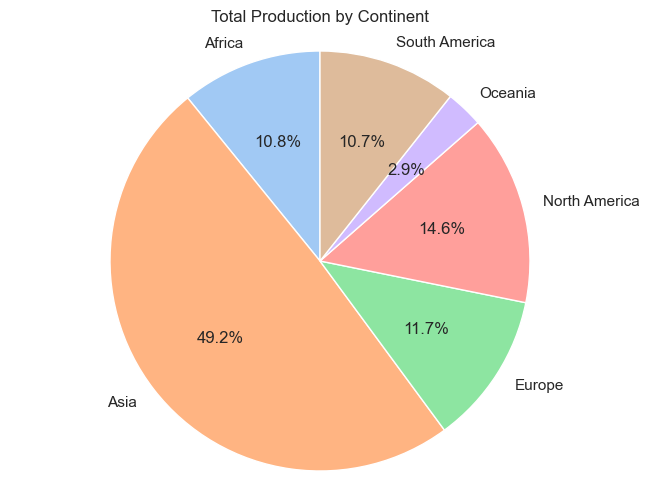

In [22]:
# Set Seaborn style
sns.set_theme(style="whitegrid")

# Summarize the total production by continent
continent_totals = summary_stats.groupby('Continent')['sum'].sum()

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(
    continent_totals, 
    labels=continent_totals.index, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=sns.color_palette('pastel'),
    wedgeprops={'edgecolor': 'white'}  # Optional: Adds a white border around slices for better readability
)

# Adding title
plt.title('Total Production by Continent')

# Display the plot
plt.axis('equal')  # Ensures the pie chart is circular
plt.show()

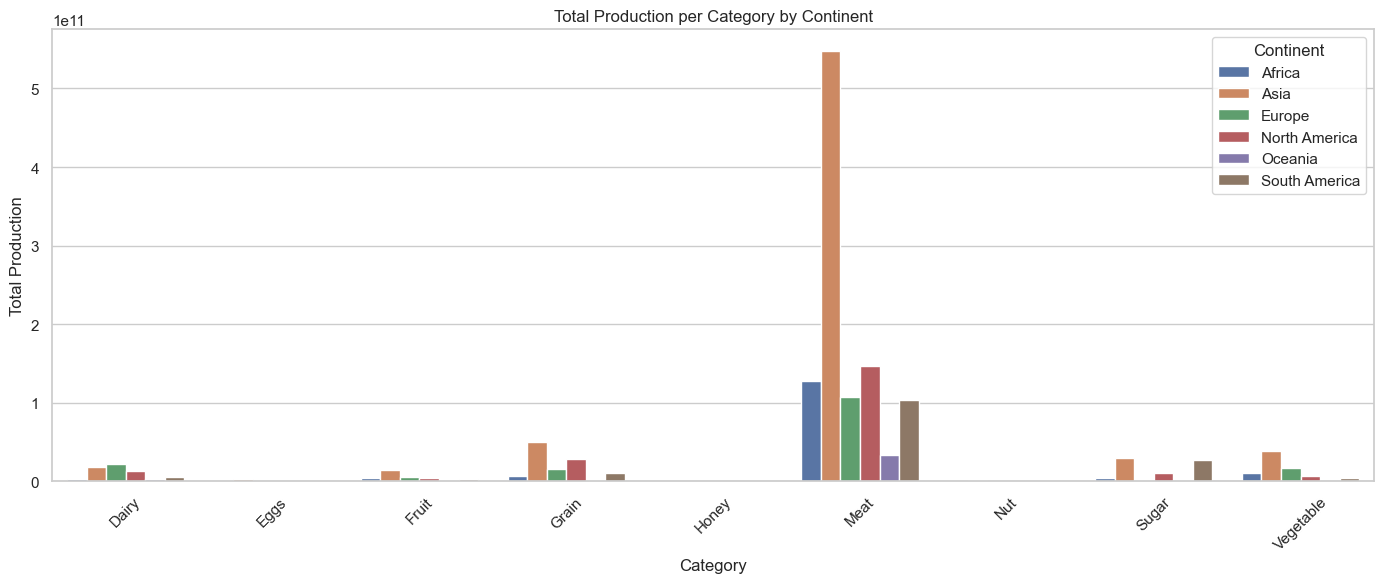

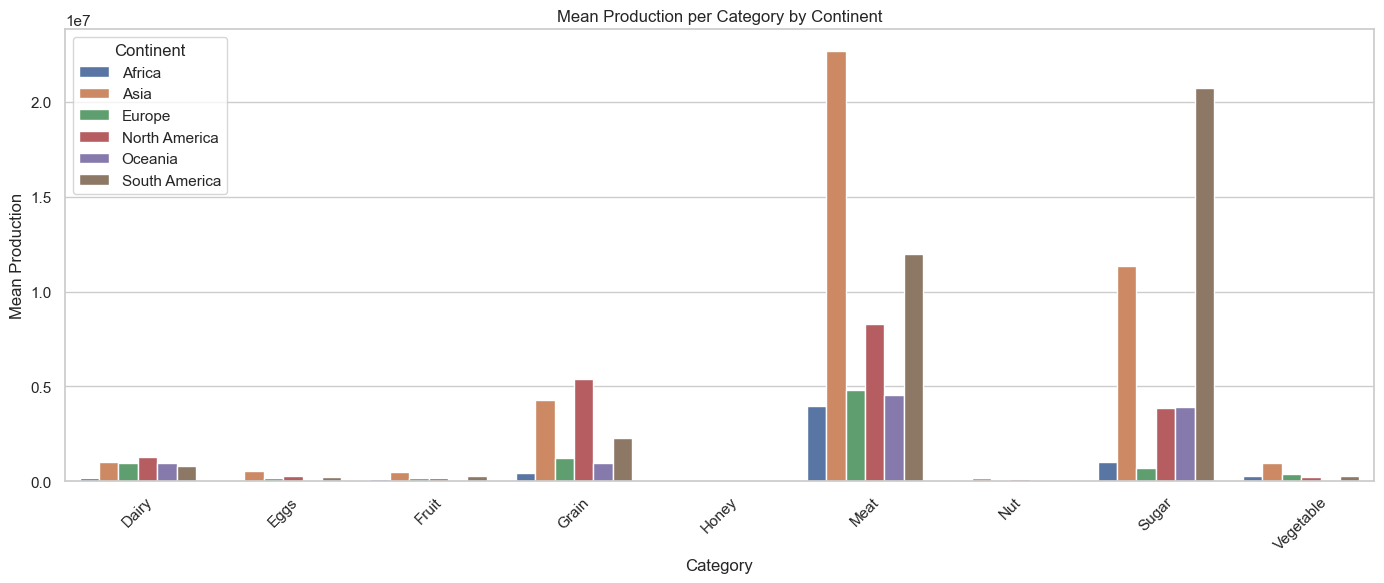

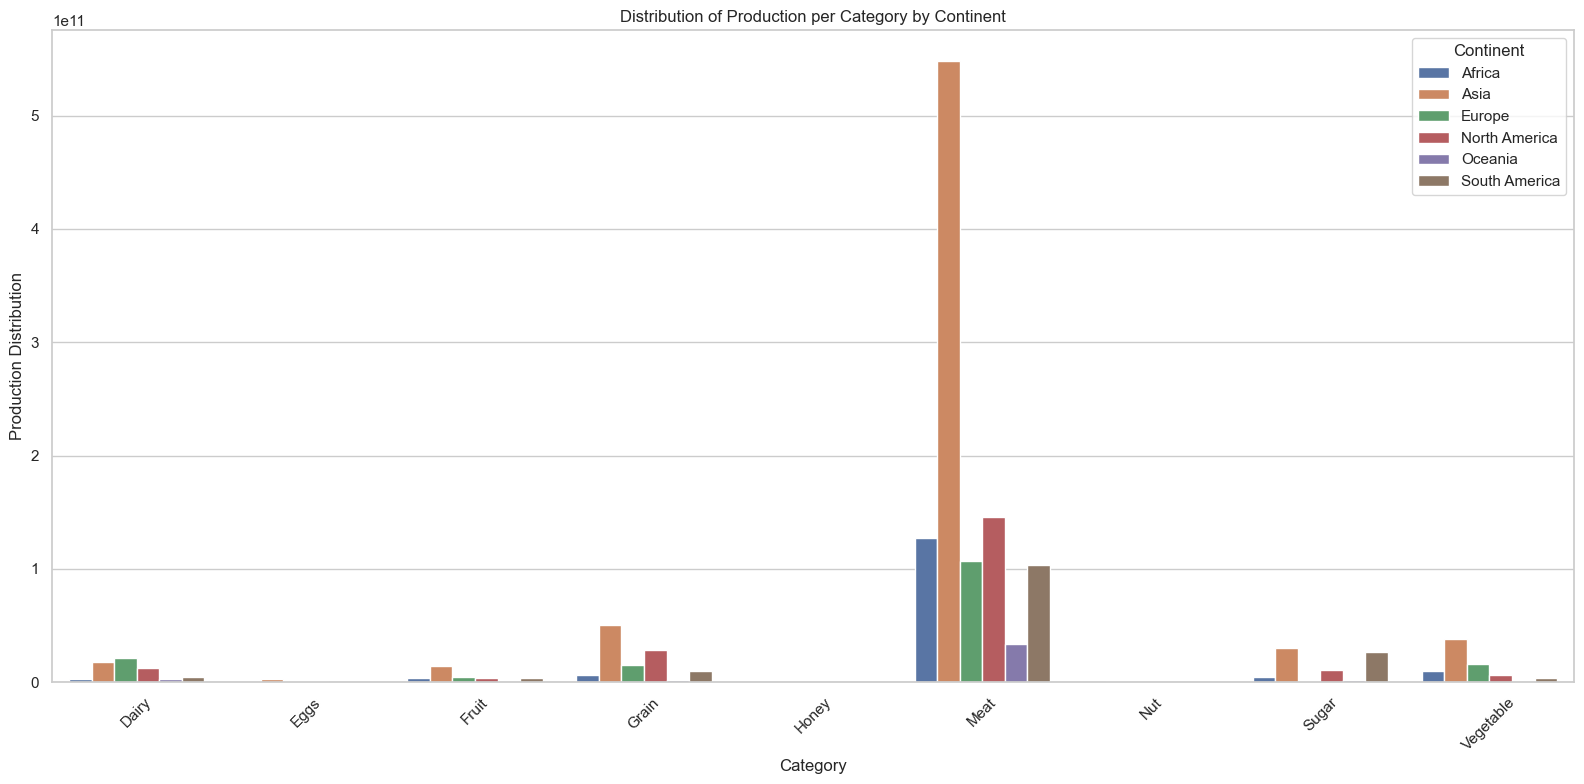

In [23]:
# Graph Statistics

# Bar Chart of Total Production per Category by Continent
plt.figure(figsize=(14, 6))
sns.barplot(data=summary_stats, x='Category', y='sum', hue='Continent', errorbar=None)
plt.title('Total Production per Category by Continent')
plt.ylabel('Total Production')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Bar Chart of Mean Production per Category by Continent
plt.figure(figsize=(14, 6))
sns.barplot(data=summary_stats, x='Category', y='mean', hue='Continent', errorbar=None)
plt.title('Mean Production per Category by Continent')
plt.ylabel('Mean Production')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Bar Chart of Production Distribution by Category and Continent
plt.figure(figsize=(16, 8))
sns.barplot(data=summary_stats, x='Category', y='sum', hue='Continent')
plt.title('Distribution of Production per Category by Continent')
plt.ylabel('Production Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [24]:
ag_df_fnl.to_csv("ag_df_fnl.csv", index=False)

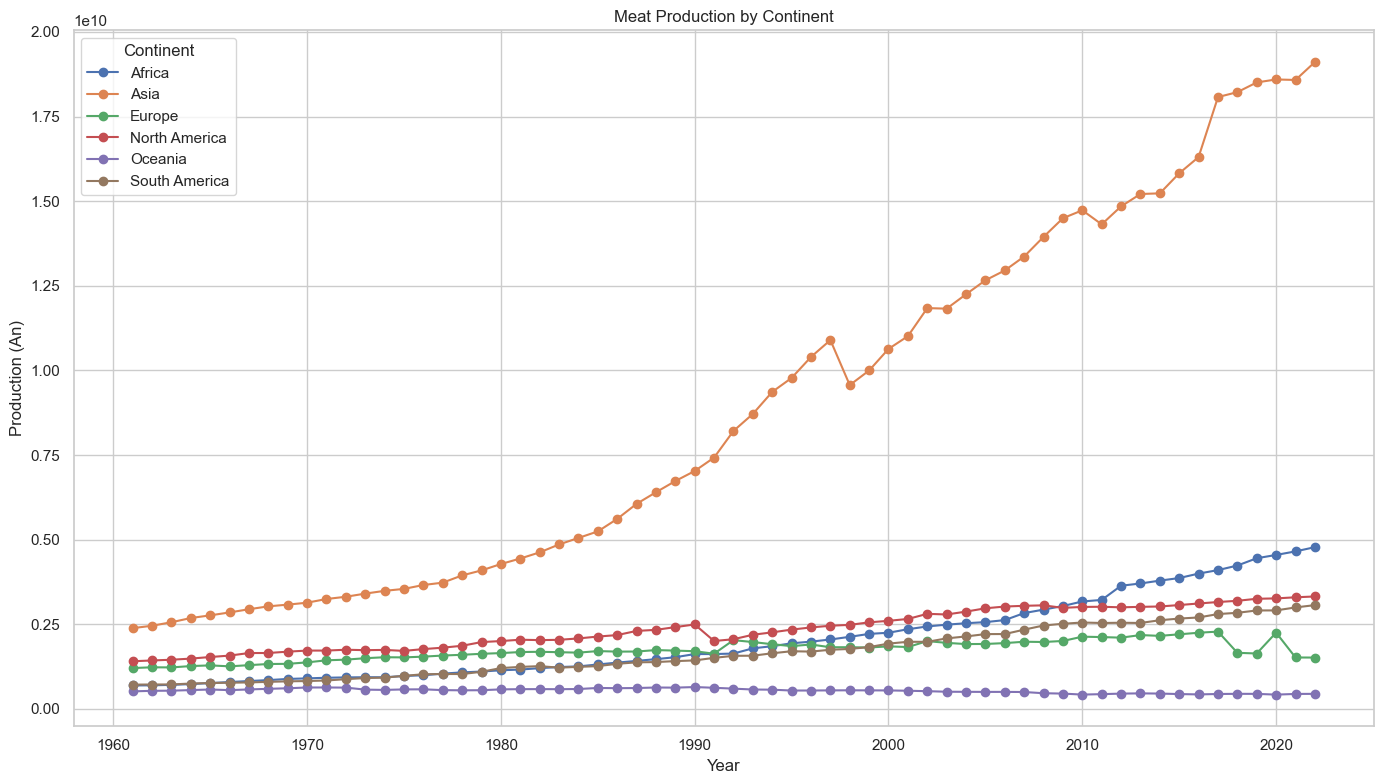

In [25]:
# Plot Category by Continent for selected category
# Filter data for the required category and unit
category = 'Meat'  #Change this to plot different categories (Great use case for dropdown)

# Create an if statement to auto select units based on what category is selected
if category == 'Meat':
    unit = 'An' # Unit of measurement 'An' for single animal
else:
    unit = 't' # Unit of measurement 't' for tonnes

# Filter the dataset for the selected category and unit
category_df = ag_df_fnl[(ag_df_fnl['Category'] == category) & (ag_df_fnl['Unit'] == unit)]

# Group by Continent and Year and sum the production values
grouped_df = category_df.groupby(['Continent']).sum(numeric_only=True).reset_index()

# Melt the DataFrame to make it easier for plotting
melted_df = pd.melt(grouped_df, id_vars=['Continent'], # Items to keep
                    value_vars=[str(year) for year in range(1961, 2023)],
                    var_name='Year', value_name='Value')

# Convert Year to datetime format for proper plotting
melted_df['Year'] = pd.to_datetime(melted_df['Year'], format='%Y')

#Plot all continents on the same graph
plt.figure(figsize=(14, 8))

# Loop through each continent and plot its data
for continent in melted_df['Continent'].unique():
    data = melted_df[melted_df['Continent'] == continent]
    plt.plot(data['Year'], data['Value'], marker='o', label=continent) # Add label = Continent 

# Adding labels and title
plt.xlabel('Year')
plt.ylabel(f'Production ({unit})')
plt.title(f'{category} Production by Continent')
plt.grid(True)

# Display legend
plt.legend(title='Continent')

# Show the plot
plt.tight_layout()
plt.show()

In [26]:
ag_df_fnl['Country'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada',
       'Caucasia', 'Central African Republic', 'Chad', 'Chile', 'China',
       'Colombia', 'Comoros', 'Cook Islands', 'Costa Rica', 'Croatia',
       'Cuba', 'Cyprus', 'Denmark', 'Djibouti', 'Dominica',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia',
       'Faroe Islands', 'Fiji', 'Finland', 'France', 'French Guiana',
       'French Polynesia', 'Gabon', 'Gambia', 'Georgia', 'Germany',
       'Ghana', 'Greece', 'Grenada', 'Guadeloupe', 'Guatemala', 'Guinea',
       'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras

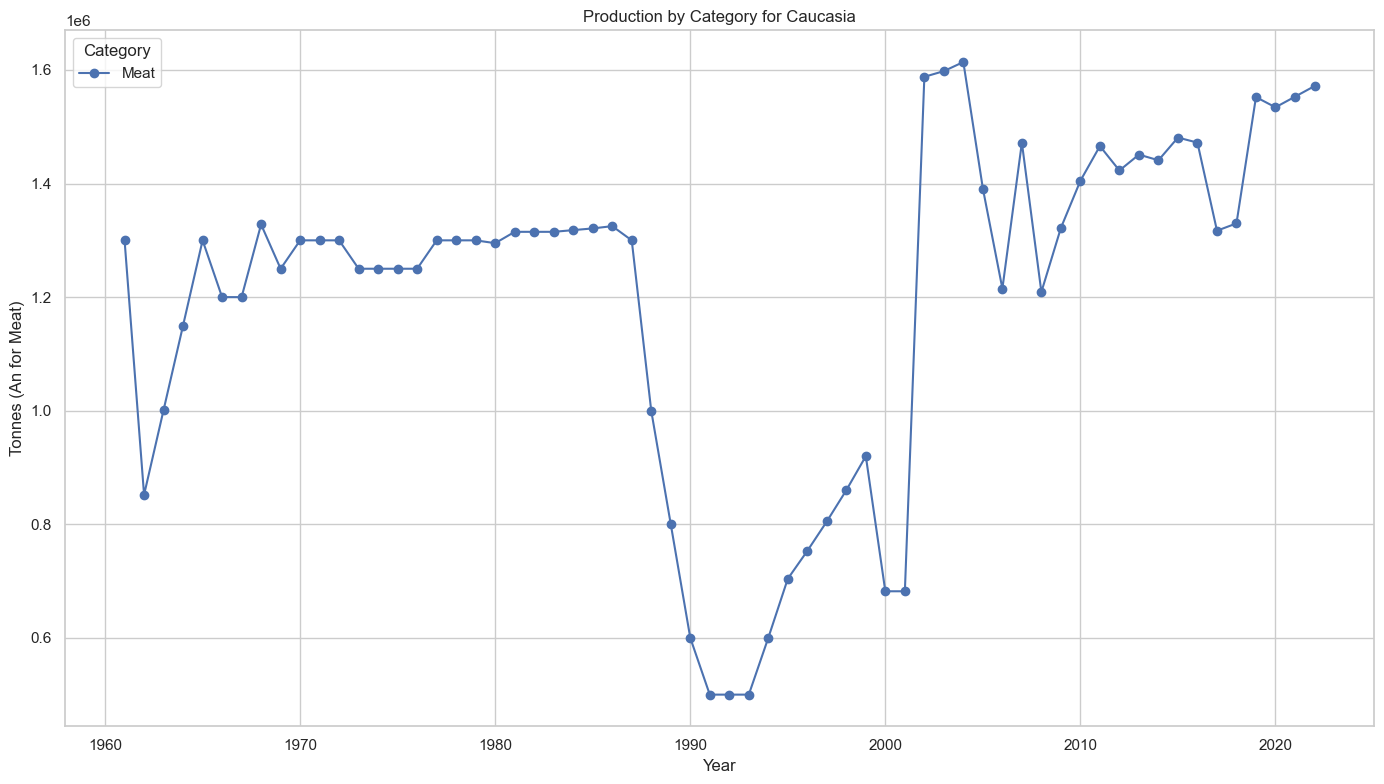

In [27]:
# Let User Select a Country , and display categories

# Filter the data for Selected Counrty
selected_country = 'Caucasia' # This would be another good place for a drop down

# Filter the dataset for the selected category and unit
country_df = ag_df_fnl[(ag_df_fnl['Country'] == selected_country)]

# Group by Country, Category, and Year and sum the production values
grouped_df = country_df.groupby(['Country', 'Category']).sum(numeric_only=True).reset_index()

# Melt the DataFrame to make it easier for plotting
melted_df = pd.melt(grouped_df, id_vars=['Country', 'Category'], 
                    value_vars=[str(year) for year in range(1961, 2023)],
                    var_name='Year', value_name='Value')

# Convert Year to datetime format for proper plotting
melted_df['Year'] = pd.to_datetime(melted_df['Year'], format='%Y')

# Plot each category as a separate line
plt.figure(figsize=(14, 8))

# Loop through each category and plot its data
for category in melted_df['Category'].unique():
    data = melted_df[melted_df['Category'] == category]
    plt.plot(data['Year'], data['Value'], marker='o', label=category)  # Add label = category

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Tonnes (An for Meat)')
plt.title(f'Production by Category for {selected_country}')
plt.grid(True)

# Display legend
plt.legend(title='Category')

# Show the plot
plt.tight_layout()
plt.show()

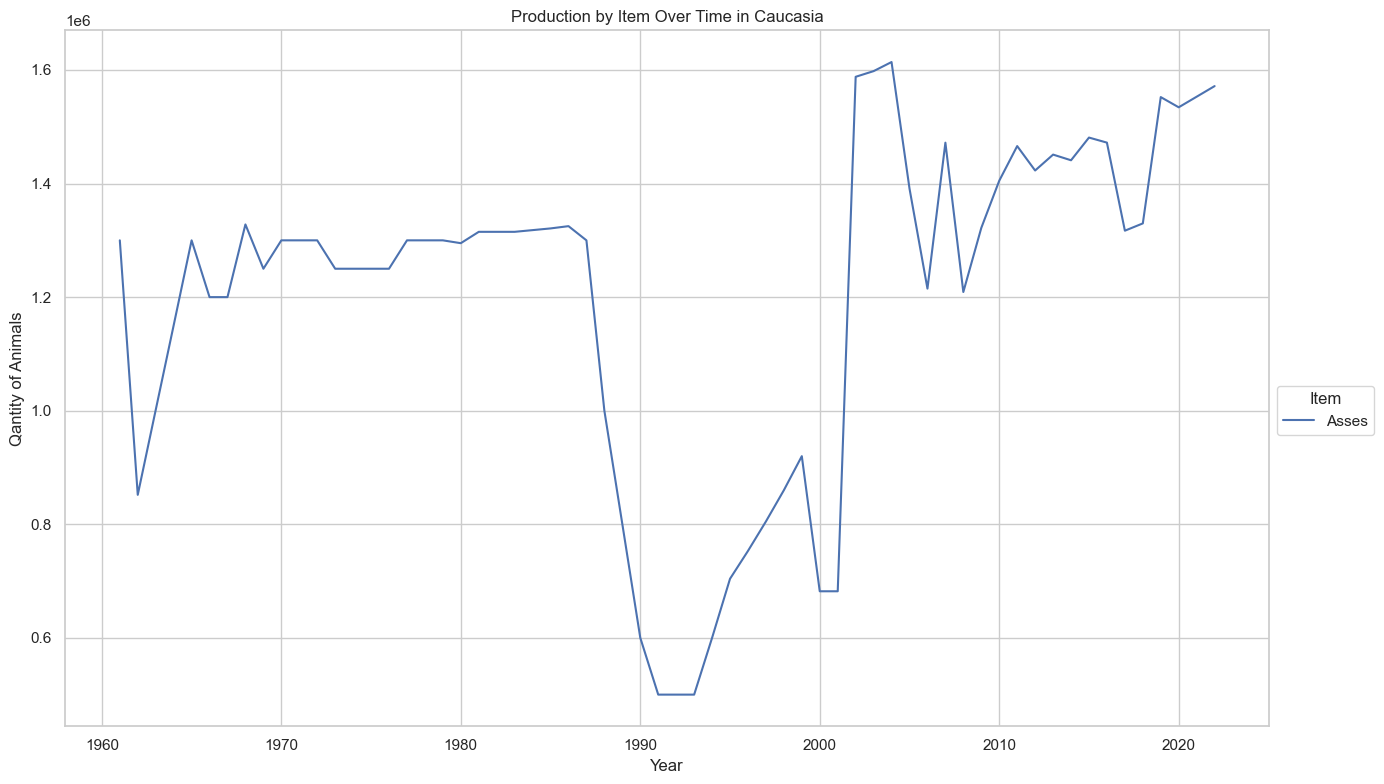

In [28]:
# Let User Select a Category, display Items vs time in graph


# Filter the data for the Category

selected_category = 'Meat' #Another good spot for dropdown menu

# Check the selected category and set the unit accordingly
if selected_category == 'Meat':
    selected_unit = 'An'
else:
    selected_unit = 't'

# Filter the dataset for the selected country, category, and unit
country_category_df = ag_df_fnl[
    (ag_df_fnl['Country'] == selected_country) &
    (ag_df_fnl['Category'] == selected_category) &
    (ag_df_fnl['Unit'] == selected_unit)  
]

# Group by Item and Year and sum the production values
grouped_item_df = country_category_df.groupby(['Item']).sum(numeric_only=True).reset_index()

# Melt the DataFrame to make it easier for plotting
melted_item_df = pd.melt(
    grouped_item_df, 
    id_vars=['Item'], 
    value_vars=[str(year) for year in range(1961, 2023)], 
    var_name='Year', 
    value_name='Production'
)

# Convert Year to datetime format for proper plotting
melted_item_df['Year'] = pd.to_datetime(melted_item_df['Year'], format='%Y')

# Plot all items in the selected category on the same graph
plt.figure(figsize=(14, 8))

# Loop through each item and plot the data
for item in melted_item_df['Item'].unique():
    data = melted_item_df[melted_item_df['Item'] == item]
    plt.plot(data['Year'], data['Production'], label=item)

# Adding labels and title
if selected_category == 'Meat':
    y_label = f'Qantity of Animals'
else:
    y_label = f'Tonnes of {selected_category}'
    
plt.xlabel('Year')
plt.ylabel(y_label)
plt.title(f'Production by Item Over Time in {selected_country}')
plt.grid(True)

# Display legend and move it from displaying over graph
plt.legend(title='Item', loc='upper left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.tight_layout()
plt.show()

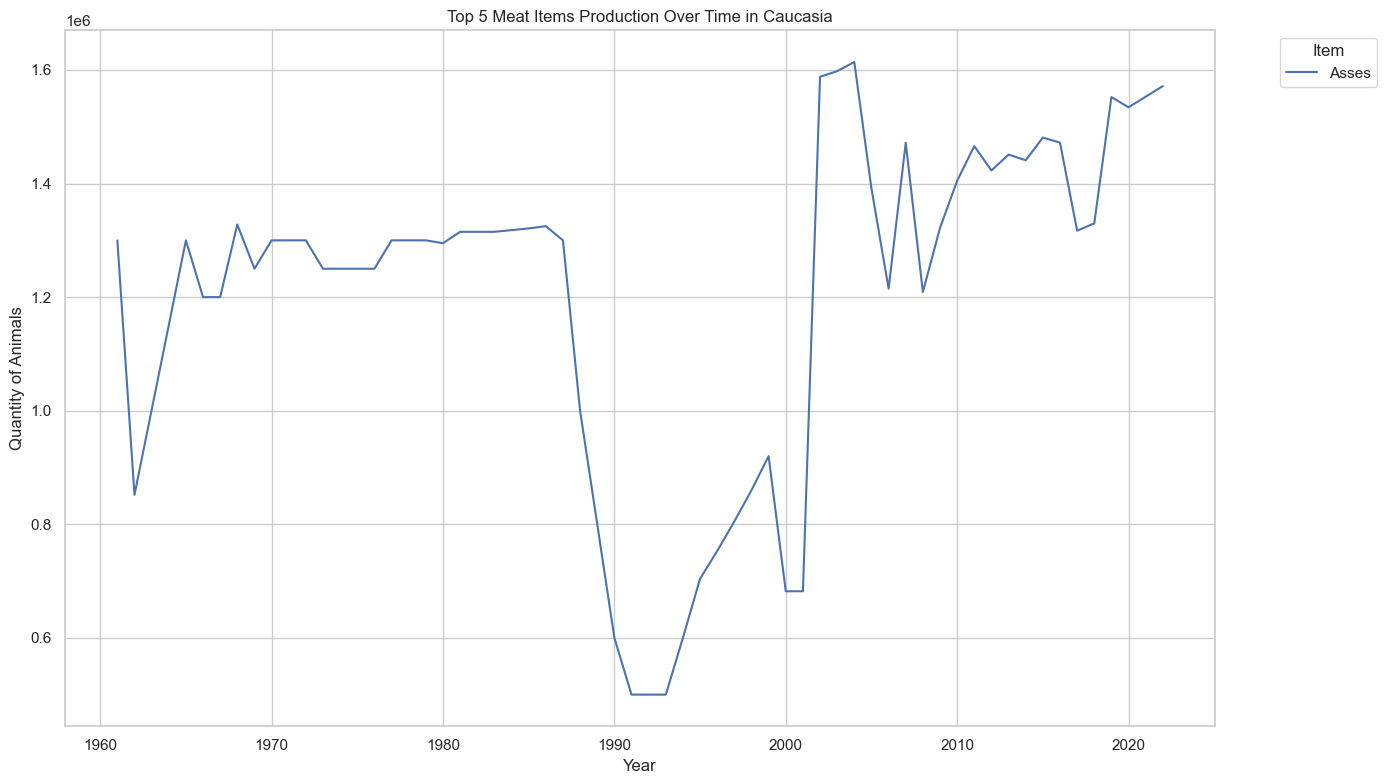

In [29]:
# Filter the data for top 5 of selected 'Category' for selected 'Country'

# Calculate the total production for each item and select the top 5 items
grouped_item_df['Total_Production'] = grouped_item_df[
    [str(year) for year in range(1961, 2023)]
].sum(axis=1)

# Get the top 5 items based on total production
top_items = grouped_item_df.nlargest(5, 'Total_Production')['Item'].tolist()

# Filter the data to include only the top 5 items
grouped_item_df = grouped_item_df[grouped_item_df['Item'].isin(top_items)]

# Melt the DataFrame to make it easier for plotting
melted_item_df = pd.melt(
    grouped_item_df,
    id_vars=['Item'],
    value_vars=[str(year) for year in range(1961, 2023)],
    var_name='Year',
    value_name='Production'
)

# Convert Year to datetime format for proper plotting
melted_item_df['Year'] = pd.to_datetime(melted_item_df['Year'], format='%Y')

# Plot all items in the selected category on the same graph
plt.figure(figsize=(14, 8))

# Loop through each item and plot the data
for item in melted_item_df['Item'].unique():
    data = melted_item_df[melted_item_df['Item'] == item]
    plt.plot(data['Year'], data['Production'], label=item)

# Adding labels and title
if selected_category == 'Meat':
    y_label = f'Quantity of Animals'
else:
    y_label = f'Tonnes of {selected_category}'

plt.xlabel('Year')
plt.ylabel(y_label)
plt.title(f'Top 5 {selected_category} Items Production Over Time in {selected_country}')
plt.grid(True)

# Display legend and move it from displaying over graph
plt.legend(title='Item', loc='upper left', bbox_to_anchor=(1.05, 1))

# Show the plot
plt.tight_layout()
plt.show()


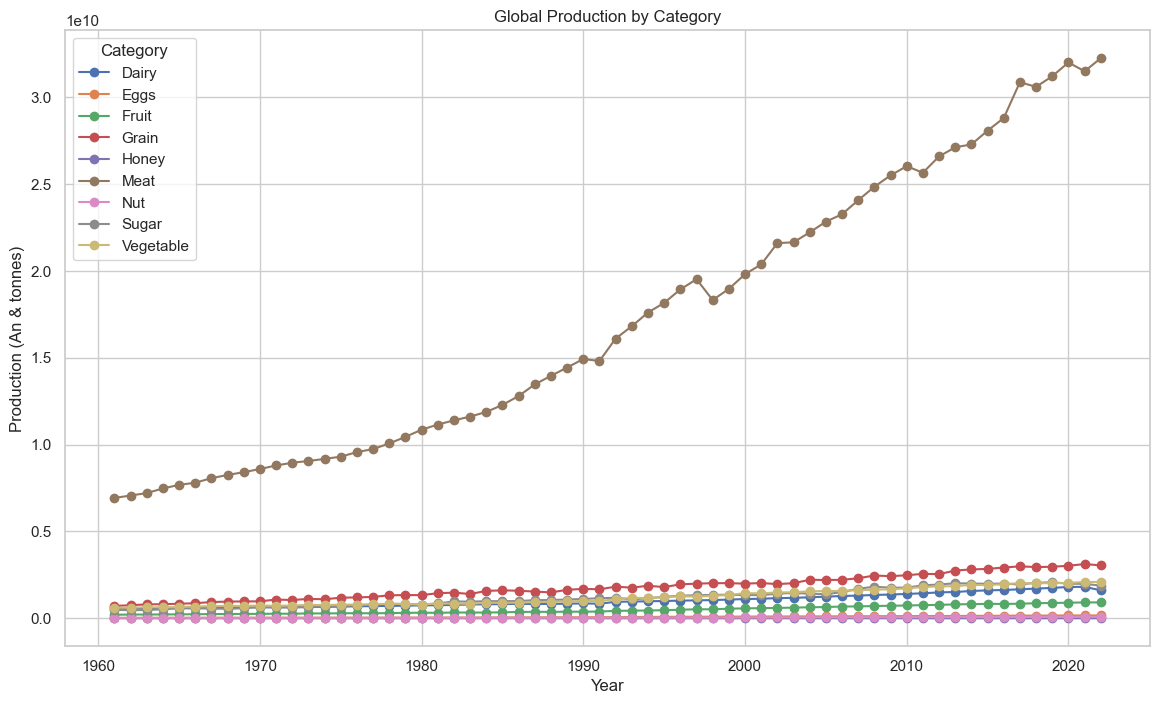

In [30]:
# Global production by Category

# Filter the dataset for the selected category and unit
global_df = ag_df_fnl.copy()

# Group by Category and Year and sum the production values
grouped_df = global_df.groupby(['Category']).sum(numeric_only=True).reset_index()

# Melt the DataFrame to make it easier for plotting
melted_df = pd.melt(grouped_df, id_vars=['Category'], 
                    value_vars=[str(year) for year in range(1961, 2023)],
                    var_name='Year', value_name='Value')

# Convert Year to datetime format for proper plotting
melted_df['Year'] = pd.to_datetime(melted_df['Year'], format='%Y')

# Plot each category as a separate line
plt.figure(figsize=(14, 8))

# Loop through each category and plot its data
for category in melted_df['Category'].unique():
    data = melted_df[melted_df['Category'] == category]
    plt.plot(data['Year'], data['Value'], marker='o', label=category)  # Add label = category

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Production (An & tonnes)')
plt.title('Global Production by Category')
plt.grid(True)

# Display legend
plt.legend(title='Category')

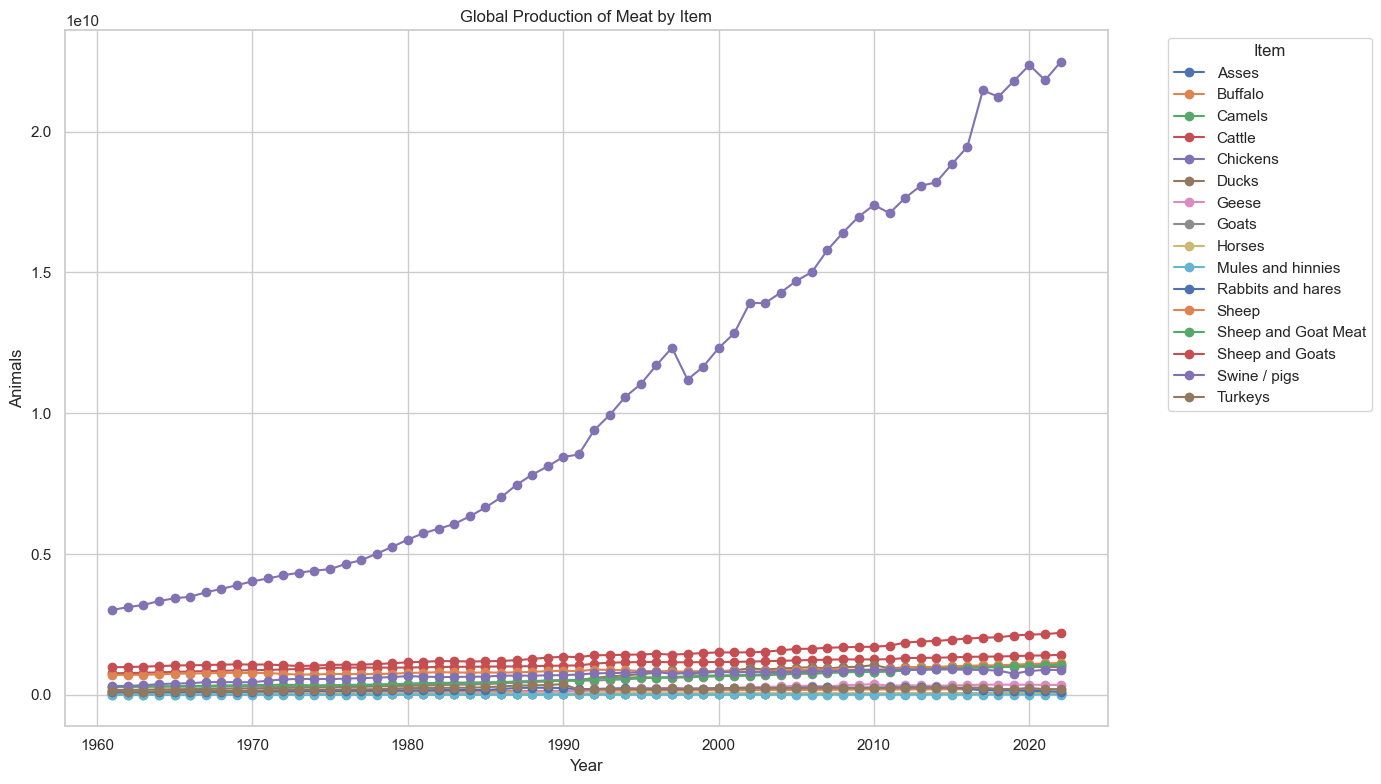

In [31]:
# Plot Global production by Category and display "Items"

# Filter the dataset for the selected category "Meat" and unit
global_df = ag_df_fnl[ag_df_fnl['Category'] == 'Meat']

# Group by Item and Year and sum the production values
grouped_df = global_df.groupby(['Item']).sum(numeric_only=True).reset_index()

# Melt the DataFrame to make it easier for plotting
melted_df = pd.melt(grouped_df, id_vars=['Item'], 
                    value_vars=[str(year) for year in range(1961, 2023)],
                    var_name='Year', value_name='Value')

# Convert Year to datetime format for proper plotting
melted_df['Year'] = pd.to_datetime(melted_df['Year'], format='%Y')

# Plot each item as a separate line
plt.figure(figsize=(14, 8))

# Loop through each item and plot its data
for item in melted_df['Item'].unique():
    data = melted_df[melted_df['Item'] == item]
    plt.plot(data['Year'], data['Value'], marker='o', label=item)  # Add label = item

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Animals')
plt.title('Global Production of Meat by Item')
plt.grid(True)

# Display legend
plt.legend(title='Item', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

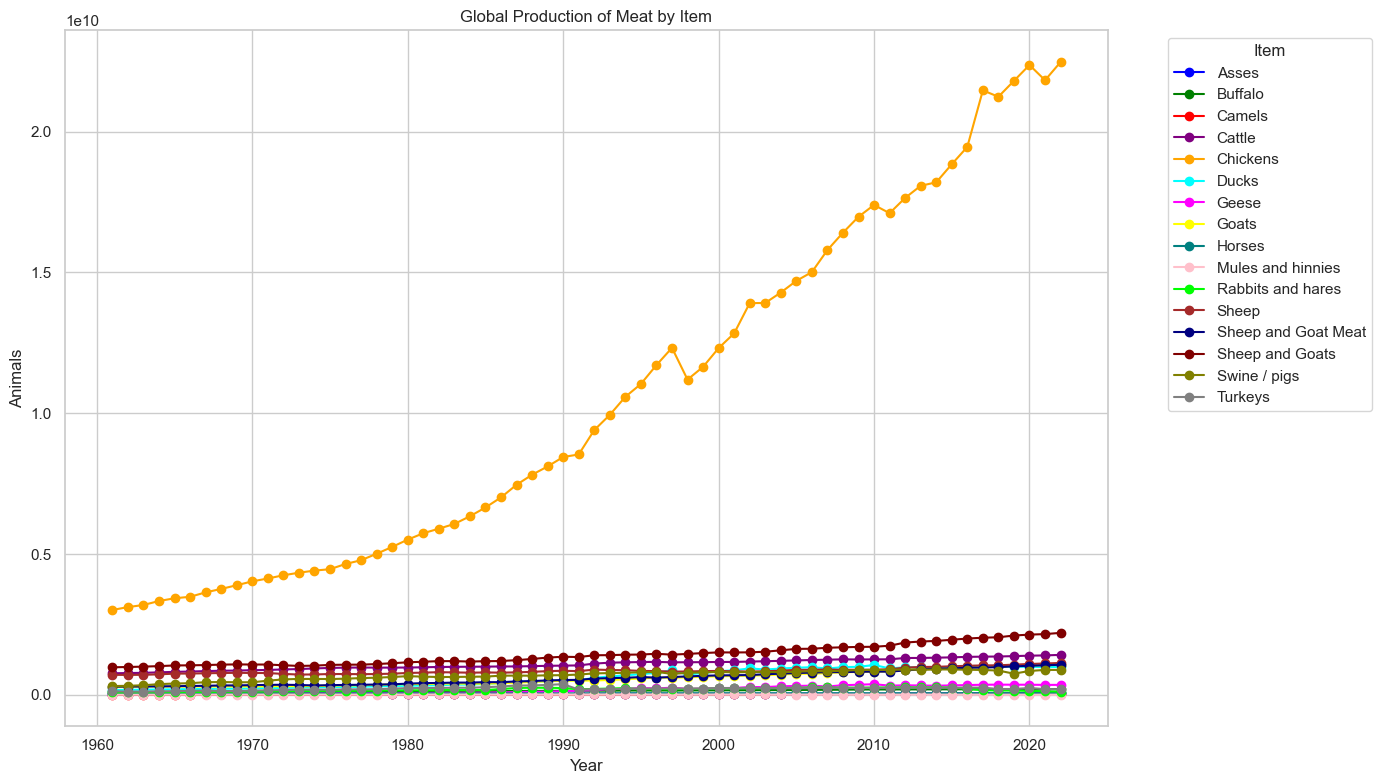

In [32]:
# Plot Global production by Category and display "Items"

# Filter the dataset for the selected category "Meat" and unit
global_df = ag_df_fnl[ag_df_fnl['Category'] == 'Meat']

# Group by Item and Year and sum the production values
grouped_df = global_df.groupby(['Item']).sum(numeric_only=True).reset_index()

# Melt the DataFrame to make it easier for plotting
melted_df = pd.melt(grouped_df, id_vars=['Item'], 
                    value_vars=[str(year) for year in range(1961, 2023)],
                    var_name='Year', value_name='Value')

# Convert Year to datetime format for proper plotting
melted_df['Year'] = pd.to_datetime(melted_df['Year'], format='%Y')

# Plot each item as a separate line with specified colors
plt.figure(figsize=(14, 8))

# Define a list of 16 distinct colors
colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta', 'yellow', 
          'teal', 'pink', 'lime', 'brown', 'navy', 'maroon', 'olive', 'gray']

# Loop through each item and plot its data with a specific color
for idx, item in enumerate(melted_df['Item'].unique()):
    data = melted_df[melted_df['Item'] == item]
    plt.plot(data['Year'], data['Value'], marker='o', label=item, color=colors[idx % len(colors)])  # Use a color from the list

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Animals')
plt.title('Global Production of Meat by Item')
plt.grid(True)

# Display legend
plt.legend(title='Item', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


In [33]:
# Summarize total production globally by year

# Melt the DataFrame to bring years as a separate column
melted_df = pd.melt(
    ag_df_fnl, 
    id_vars=['Country', 'Category', 'Item', 'Unit'],  
    var_name='Year', 
    value_name='Production'
)

# Convert melted_df to datetime format
melted_df['Year'] = pd.to_datetime(melted_df['Year'], format='%Y', errors='coerce')

# Filter to only valid years
melted_df = melted_df.dropna(subset=['Year'])

# Group by Year and sum Production to get global totals
total_production_df = melted_df.groupby('Year')['Production'].sum().reset_index()

# Rename for clarity
total_production_df.rename(columns={'Production': 'Total_Production'}, inplace=True)

# Display the resulting DataFrame
display(total_production_df.head())

,Year,Total_Production
0,1961-01-01,9543673729.110001
1,1962-01-01,9736306836.750002
2,1963-01-01,9954818863.09
3,1964-01-01,10287924767.249996
4,1965-01-01,10606842395.059996


In [34]:
#Display world population datasets and merge them on Country

display(world_population.head())
display(world_population_all_years.head())

,rank,Country,Continent,area (km²),density (km²),growth rate,world percentage
0,1,India,Asia,3287590.0,481,0.81%,17.85%
1,2,China,Asia,9706961.0,151,-0.02%,17.81%
2,3,United States,North America,9372610.0,37,0.50%,4.25%
3,4,Indonesia,Asia,1904569.0,148,0.74%,3.47%
4,5,Pakistan,Asia,881912.0,312,1.98%,3.00%


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54608.0,55811.0,56682.0,57475.0,58178.0,58782.0,...,103594.0,104257.0,104874.0,105439.0,105962.0,106442.0,106585.0,106537.0,106445.0,106277.0
1,Africa Eastern and Southern,AFE,"Population, total",SP.POP.TOTL,130692579.0,134169237.0,137835590.0,141630546.0,145605995.0,149742351.0,...,583651101.0,600008424.0,616377605.0,632746570.0,649757148.0,667242986.0,685112979.0,702977106.0,720859132.0,739108306.0
2,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8622466.0,8790140.0,8969047.0,9157465.0,9355514.0,9565147.0,...,32716210.0,33753499.0,34636207.0,35643418.0,36686784.0,37769499.0,38972230.0,40099462.0,41128771.0,42239854.0
3,Africa Western and Central,AFW,"Population, total",SP.POP.TOTL,97256290.0,99314028.0,101445032.0,103667517.0,105959979.0,108336203.0,...,397855507.0,408690375.0,419778384.0,431138704.0,442646825.0,454306063.0,466189102.0,478185907.0,490330870.0,502789511.0
4,Angola,AGO,"Population, total",SP.POP.TOTL,5357195.0,5441333.0,5521400.0,5599827.0,5673199.0,5736582.0,...,27128337.0,28127721.0,29154746.0,30208628.0,31273533.0,32353588.0,33428486.0,34503774.0,35588987.0,36684202.0


In [35]:
# Remove 'Indicator Code' column and rename 'Country Name' to 'Country', merge on 'Country' using "inner"
columns_to_drop3 =["Indicator Code"]
world_population_all_years.drop(columns=columns_to_drop3, inplace=True)
world_population_all_years.rename(columns={"Country Name": "Country"}, inplace=True)

# Merge DF's
merged_pop_data = pd.merge(world_population_all_years, world_population, on= "Country", how="inner")

#Display DF
merged_pop_data.head()

,Country,Country Code,Indicator Name,1960,1961,1962,1963,1964,1965,1966,...,2020,2021,2022,2023,rank,Continent,area (km²),density (km²),growth rate,world percentage
0,Aruba,ABW,"Population, total",54608.0,55811.0,56682.0,57475.0,58178.0,58782.0,59291.0,...,106585.0,106537.0,106445.0,106277.0,198,North America,180.0,590,-0.16%,0.00%
1,Afghanistan,AFG,"Population, total",8622466.0,8790140.0,8969047.0,9157465.0,9355514.0,9565147.0,9783147.0,...,38972230.0,40099462.0,41128771.0,42239854.0,36,Asia,652230.0,65,2.70%,0.53%
2,Angola,AGO,"Population, total",5357195.0,5441333.0,5521400.0,5599827.0,5673199.0,5736582.0,5787044.0,...,33428486.0,34503774.0,35588987.0,36684202.0,42,Africa,1246700.0,29,3.08%,0.46%
3,Albania,ALB,"Population, total",1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,1914573.0,...,2837849.0,2811666.0,2777689.0,2745972.0,138,Europe,28748.0,103,-0.35%,0.04%
4,Andorra,AND,"Population, total",9443.0,10216.0,11014.0,11839.0,12690.0,13563.0,14546.0,...,77700.0,79034.0,79824.0,80088.0,203,Europe,468.0,170,0.33%,0.00%


In [36]:
merged_pop_data.to_csv("merged_pop_data.csv", index=False)

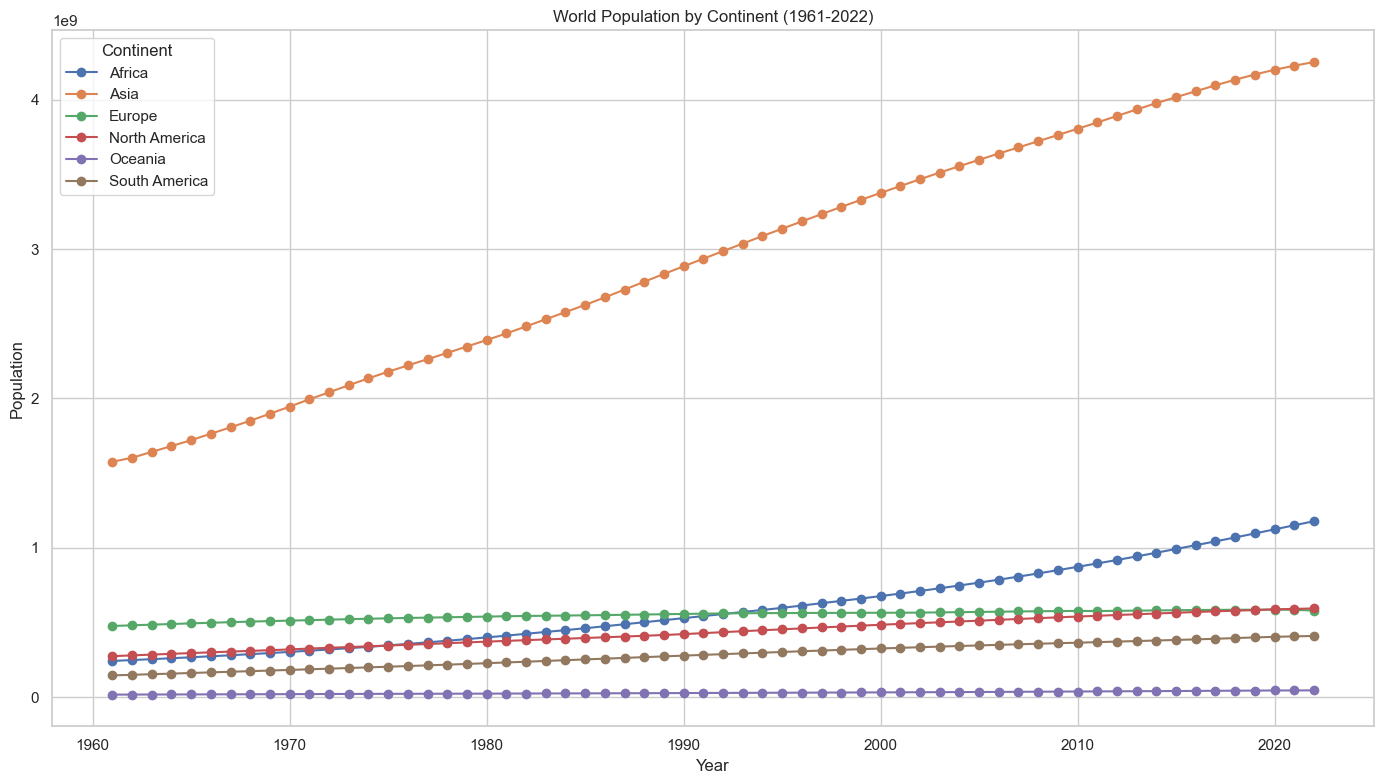

In [37]:
# Graph popultation data by continent over time
# Group by Continent and sum the population values for each year
pop_grouped = merged_pop_data.groupby(['Continent']).sum(numeric_only=True).reset_index()

# Melt the DataFrame to make it easier for plotting
melted_pop_df = pd.melt(pop_grouped, id_vars=['Continent'], 
                        value_vars=[str(year) for year in range(1961, 2023)],
                        var_name='Year', value_name='Population')

# Convert Year to datetime format for proper plotting
melted_pop_df['Year'] = pd.to_datetime(melted_pop_df['Year'], format='%Y')

# Plot all continents on the same graph
plt.figure(figsize=(14, 8))

# Loop through each continent and plot its data
for continent in melted_pop_df['Continent'].unique():
    data = melted_pop_df[melted_pop_df['Continent'] == continent]
    plt.plot(data['Year'], data['Population'], marker='o', label=continent)

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Population')
plt.title('World Population by Continent (1961-2022)')
plt.grid(True)

# Display legend
plt.legend(title='Continent')

# Show the plot
plt.tight_layout()
plt.show()

In [38]:
# Summarize total world population by year

# Melt the DataFrame to bring years as a separate column
melted_pop_df = pd.melt(
    merged_pop_data, 
    id_vars=['Country'], 
    var_name='Year', 
    value_name='Population'
)

# Change 'Year' to datetime format
melted_pop_df['Year'] = pd.to_datetime(melted_pop_df['Year'], format='%Y', errors='coerce')

# Filter to only valid years 
melted_pop_df = melted_pop_df.dropna(subset=['Year'])

# Group by Year and sum Population to get global totals
total_population_df = melted_pop_df.groupby('Year')['Population'].sum().reset_index()

# Rename for clarity
total_population_df.rename(columns={'Population': 'Total_Population'}, inplace=True)

# Display the resulting DataFrame
display(total_population_df.head())


,Year,Total_Population
0,1960-01-01,2693766885.0
1,1961-01-01,2727582038.0
2,1962-01-01,2774652323.0
3,1963-01-01,2833631763.0
4,1964-01-01,2892969255.0


In [39]:
#Merge Ag and population data
final_merge = pd.merge(total_population_df, total_production_df, on= "Year", how="inner")
final_merge.info()
final_merge.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Year              62 non-null     datetime64[ns]
 1   Total_Population  62 non-null     object        
 2   Total_Production  62 non-null     object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.6+ KB


,Year,Total_Population,Total_Production
0,1961-01-01,2727582038.0,9543673729.110001
1,1962-01-01,2774652323.0,9736306836.750002
2,1963-01-01,2833631763.0,9954818863.09
3,1964-01-01,2892969255.0,10287924767.249996
4,1965-01-01,2952982632.0,10606842395.059996


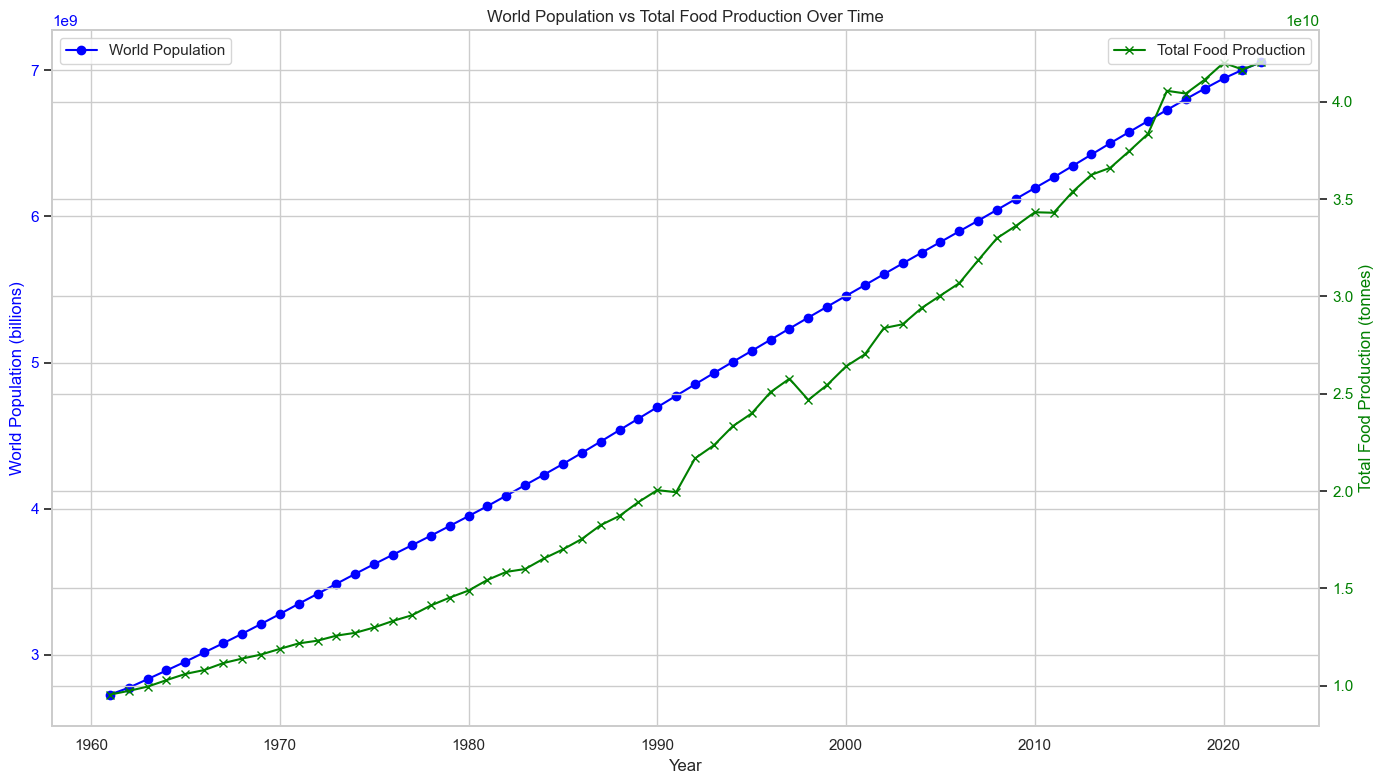

In [40]:
# Plot World Population vs World Food Production

# Create a figure and a set of subplots with dual y-axes
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot world population on the first y-axis
ax1.plot(final_merge['Year'], final_merge['Total_Population'], color='blue', marker='o', label='World Population')
ax1.set_xlabel('Year')
ax1.set_ylabel('World Population (billions)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis to plot food production
ax2 = ax1.twinx()
ax2.plot(final_merge['Year'], final_merge['Total_Production'], color='green', marker='x', label='Total Food Production')
ax2.set_ylabel('Total Food Production (tonnes)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add a title to the plot
plt.title('World Population vs Total Food Production Over Time')

# Add legends for each line
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()




In [41]:
final_merge.corr()

,Year,Total_Population,Total_Production
Year,1.000000,0.999631,0.985126
Total_Population,0.999631,1.000000,0.988942
Total_Production,0.985126,0.988942,1.000000


In [42]:
# Calculate the Pearson correlation coefficient

pearson_corr, _ = pearsonr(final_merge['Total_Population'], final_merge['Total_Production'])
print(f"Pearson correlation coefficient: {pearson_corr}")

# Calculate the Spearman correlation coefficient

spearman_corr, _ = spearmanr(final_merge['Total_Population'], final_merge['Total_Production'])
print(f"Spearman correlation coefficient: {spearman_corr}")

Pearson correlation coefficient: 0.9889417020080836
Spearman correlation coefficient: 0.9995467250887664
